# Exploring Space Launch Success
In this notebook, you can use Python3 to explore a sample dataset scraped from [Next Spaceflight](https://nextspaceflight.com/launches/past/?page=1). Data are obtained from [@agirlcoding](https://www.kaggle.com/agirlcoding) on [Kaggle](https://www.kaggle.com/agirlcoding/all-space-missions-from-1957).

In [146]:
# set up python environment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
%matplotlib inline

# import raw dataset
df = pd.read_csv('./datasets_828921_1417131_Space_Corrected.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


In [147]:
# Rename columns to remove spaces
df = df.rename(columns={"Company Name": "Company_Name", "Status Rocket": "Rocket_Status", "Status Mission": "Mission_Status", " Rocket": "Rocket_Price"})

# Function for creating new column for Success/Failure. Recode partial and prelaunch failures as failures.
def Success_Fail(series):
	if series == 'Prelaunch Failure':
		return "Failure"
	elif series == 'Partial Failure':
		return "Failure"
	elif series == 'Failure':
		return "Failure"
	elif series == 'Success':
		return "Success"

# Apply function to 'Mission_Status' and create 'SucessFail'
df['SucessFail'] = df['Mission_Status'].apply(Success_Fail)

# Confirm function has worked
df.SucessFail.unique()

array(['Success', 'Failure'], dtype=object)

In order to explore temporal patterns, we need columns with the year, month, week, etc. We need to create these columns from the 'Datum' column that contains date information as a string. 

In [148]:
# Datum column contains date information, but is not usable for temporal calculations. 
df.Datum.unique()

# function to return date portion of string
def get_date_chars(string):
    return str(string)[4:16]
df["date_string"] = df['Datum'].apply(get_date_chars)

# Strip out the commas from newly created date string
df["date_string"] = df.date_string.replace(',','', regex=True)

# function to return a date_time field
def get_date_time(string):
    return datetime.strptime(string, "%b %d %Y")
df["date_time"] = df['date_string'].apply(get_date_time)

# Create Fields for Year, Month and Week
df['YEAR'] = pd.DatetimeIndex(df['date_time']).year
df['MONTH'] = pd.DatetimeIndex(df['date_time']).month
df['WEEK'] = df['date_time'].dt.isocalendar().week

# Create field for weekday
def get_date_chars(string):
    return str(string)[0:3]
df["WEEKDAY"] = df['Datum'].apply(get_date_chars)

# Clean up Rocket_Price
df["Rocket_Price"] = df.Rocket_Price.replace(',','', regex=True) # strip commas
df['Rocket_Price'] = pd.to_numeric(df['Rocket_Price']) # Convert Rocket Price to numeric

# Create dataframe with fields we want to explore
space_df = df[['SucessFail', 'Company_Name', 'Rocket_Price', 'date_time', 'YEAR', 'MONTH', 'WEEK', 'WEEKDAY']]

# create dummy columns for success/fail
sf = pd.get_dummies(space_df['SucessFail'])

# combine resulting dataframe with space_df
frames = [space_df, sf] # create list of dataframes to combine
space_df = pd.concat(frames, axis=1) # concatenate the frames

# look at dataset
space_df.head()

,SucessFail,Company_Name,Rocket_Price,date_time,YEAR,MONTH,WEEK,WEEKDAY,Failure,Success
0,Success,SpaceX,50.00,2020-08-07,2020,8,32,Fri,0,1
1,Success,CASC,29.75,2020-08-06,2020,8,32,Thu,0,1
2,Success,SpaceX,NaN,2020-08-04,2020,8,32,Tue,0,1
3,Success,Roscosmos,65.00,2020-07-30,2020,7,31,Thu,0,1
4,Success,ULA,145.00,2020-07-30,2020,7,31,Thu,0,1


# Question: Has success rate improved through time? 

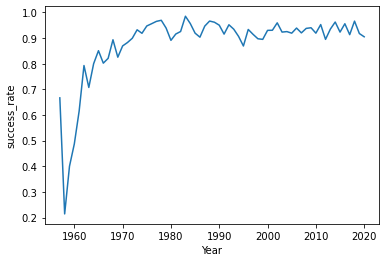

In [149]:
# Create df with each row = year, columns = ['YEAR' 'success_rate', 'n']
# Get Success Rate by year
success_rate = space_df.groupby(['YEAR'])['Success'].mean()
# Get N
year_launches = space_df.YEAR.value_counts()
# Get mean money spent by year
rocket_costs = space_df.groupby(['YEAR'])['Rocket_Price'].mean()

# Combine summary dat
frames = [success_rate, year_launches, rocket_costs]
YEAR_df = pd.concat(frames, axis=1)
YEAR_df = YEAR_df.rename(columns={"Success": "success_rate", "YEAR": "Launches"})
YEAR_df['YEAR'] = YEAR_df.index

# Plot sucess by year
YEAR_df.sort_values(by=['YEAR']).success_rate.plot(kind="line", use_index=True)
plt.xlabel('Year')
plt.ylabel('success_rate')
plt.show()

We can smooth this plot by taking a running average.

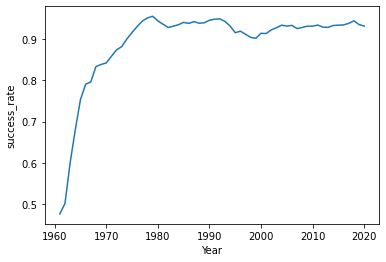

In [150]:
# Smooth data with 5 year running average
YEAR_df['success_mv_ave'] = YEAR_df.sort_values(by=['YEAR']).success_rate.rolling(window=5).mean()

# Plot smoothed sucess by year
YEAR_df.sort_values(by=['YEAR']).success_mv_ave.plot(kind="line", use_index=True)
plt.xlabel('Year')
plt.ylabel('success_rate')
plt.show()

Success rate appears to stabalize after 1980. Let's look at the number of launches per year. 

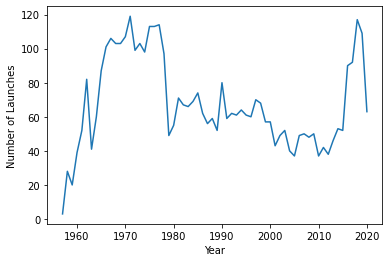

In [151]:
# Plot launches by year
YEAR_df.sort_values(by=['YEAR']).Launches.plot(kind="line", use_index=True)
plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.show()

While launch success has remained fairly constant since the mid-70's, the number of launches has changed substantially. Decreases from the 70's through the great recession of 2008-2010 are apparent, but dramatic increases in launches from 2013 through the present are likely a result of the rush to add new remote sensing platforms in orbit. The final year 2020 is not complete, and hence shows a substantial drop in total launches. We could drop 2020 to clean up the figure. 

# Question: Which company has highest success rate? 
Here, we will look at the success rate of each company. Success is defined as the proportion of total launches that were a success. 

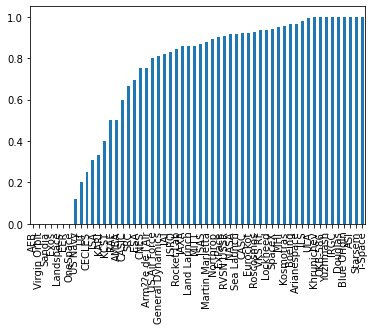

In [152]:
# Create df that contains the success rate for each company. 
# each row = company; columns = ['Company_Name' 'success_rate', 'n']
# Get Success Rate by company
success_rate = space_df.groupby(['Company_Name'])['Success'].mean()

# Get number of launches
company_n = space_df.Company_Name.value_counts()

# Combine summary dat
frames = [success_rate, company_n] # create list of dataframes to combine
company_df = pd.concat(frames, axis=1) # concatenate the frames

# Rename columns since the value_counts function adds the column name as the new name, which is unhelpful. 
company_df = company_df.rename(columns={"Success": "success_rate", "Company_Name": "Launches"})

# Add Company_Name as a column in addition to it being the index
company_df['Company_Name'] = company_df.index

# plot success rate by company
company_df.success_rate.sort_values().plot(kind="bar", use_index=True)
plt.show()


The formatting of this figure is poor since there a lot of companies, but we can see that most companies have success rates above 0.8. Some companies have only a few launches; we might want to consider only those with enough launches to be indicative of their actual performance. We could look at sample sizes and significance, but for now, let's just consider a sample size of 10. 

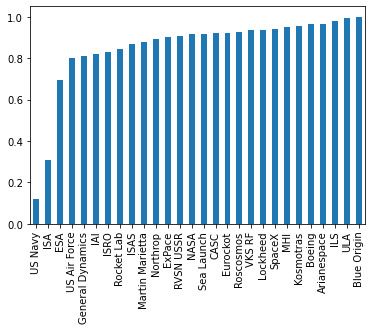

,success_rate,Launches,Company_Name
Blue Origin,1.000000,12,Blue Origin
ULA,0.992857,140,ULA
ILS,0.978261,46,ILS
Arianespace,0.964158,279,Arianespace
Boeing,0.963235,136,Boeing
Kosmotras,0.954545,22,Kosmotras
MHI,0.952381,84,MHI
SpaceX,0.940000,100,SpaceX
Lockheed,0.936709,79,Lockheed
VKS RF,0.935323,201,VKS RF


In [153]:
# Create dataset with companies that have 10 or more launches
company_df_g10 = company_df[company_df['Launches'] >= 10]

# plot success rate by company & look at values
company_df_g10.success_rate.sort_values().plot(kind="bar", use_index=True)
plt.show()

company_df_g10.sort_values(by=['success_rate'], ascending=False)

Blue Origin, a company from Texas USA, appears to have the highest success rate, with 12 launches, and the US Navy appears to have the worst success rate with 17 launches. It would be interesting to explore why the Navy has such a low success rate. Similarly, the ISA (from Iran) has a very poor success rate. 

# Question: Do companies that spend more have higher success rates?

In [154]:
# Get average amount of money spent on launches
money_spent = space_df.groupby(['Company_Name'])['Rocket_Price'].mean()

# Combine summary dat
frames = [company_df, money_spent] # create list of dataframes to combine
company_df = pd.concat(frames, axis=1) # concatenate the frames

# Look at summary data again
company_df.head()


,success_rate,Launches,Company_Name,Rocket_Price
Company_Name,,,,
AEB,0.000000,3,AEB,NaN
AMBA,0.500000,8,AMBA,NaN
ASI,1.000000,9,ASI,NaN
Arianespace,0.964158,279,Arianespace,170.260417
Arm??e de l'Air,0.750000,4,Arm??e de l'Air,NaN


There are missing values in the 'Rocket_Price'. The mean function ignores these missing values, but it looks like many companies have not reported Rocket_Price, we will have to drop these companies. 

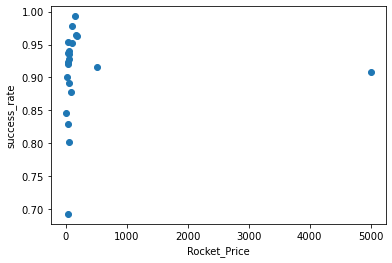

In [155]:
# Create dataset with companies that have 10 or more launches
company_df_g10 = company_df[company_df['Launches'] >= 10]

# Create dataset with companies that have reported Rocket_Price
company_df_rktpce = company_df_g10.dropna()

# plot the amount of money 
plt.plot(company_df_rktpce['Rocket_Price'], company_df_rktpce['success_rate'], 'o');
plt.xlabel('Rocket_Price')
plt.ylabel('success_rate')
plt.show()


It doesn't look like there is much of a relationship here, though there is one outlier that we might want to remove. It looks like there was one rocket with a cost of 5000 million. This is likely an error or other mistake.

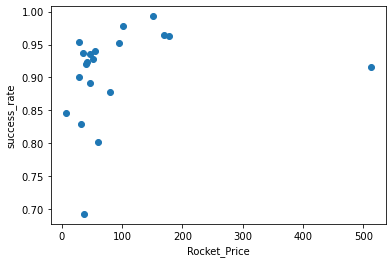

In [156]:
# Drop company with Rocket_Price error. 
company_df_rktpce = company_df_rktpce[company_df_rktpce['Rocket_Price'] < 1000]

# plot the amount of money 
plt.plot(company_df_rktpce['Rocket_Price'], company_df_rktpce['success_rate'], 'o');
plt.xlabel('Rocket_Price')
plt.ylabel('success_rate')
plt.show()

There is still no apparent trend, but again, there is one outlier. This may not be a mistake, we would need to investigate further. But let's look at the relationship if we drop this outlier. 

In [157]:
# Look at Rocket_Price
company_df_rktpce.sort_values(by=['Rocket_Price'], ascending=False)

,success_rate,Launches,Company_Name,Rocket_Price
Company_Name,,,,
NASA,0.916256,203,NASA,511.946309
Boeing,0.963235,136,Boeing,177.285714
Arianespace,0.964158,279,Arianespace,170.260417
ULA,0.992857,140,ULA,151.000000
ILS,0.978261,46,ILS,101.538462
MHI,0.952381,84,MHI,95.472973
Martin Marietta,0.877193,114,Martin Marietta,80.155556
US Air Force,0.801242,161,US Air Force,59.650769
SpaceX,0.940000,100,SpaceX,54.989899


It looks like NASA has spent, on average, 511 million per rocket. This may or may not be a mistake, but let's look at the relationship without NASA.

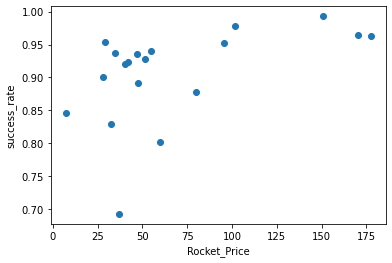

In [158]:
# Drop NASA
company_df_rktpce = company_df_rktpce[company_df_rktpce['Company_Name'] != 'NASA']

# plot the amount of money 
plt.plot(company_df_rktpce['Rocket_Price'], company_df_rktpce['success_rate'], 'o');
plt.xlabel('Rocket_Price')
plt.ylabel('success_rate')
plt.show()

There may be a relationship between Rocket Price and Success rate. We can check using a simple linear model.

In [159]:
# Create simple linear fit model to see if Rocket Price is indicative of Success.

# create dataframe for X,y
X = company_df_rktpce[['Rocket_Price']]
y = company_df_rktpce[['success_rate']]

# split out some training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

# initialize and fit model
lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train) 

# predict response with testing dataset 
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train) 

# look at simple test metric of R2
train_score = r2_score(y_train, y_train_preds)
print(train_score)
test_score = r2_score(y_test, y_test_preds)
print(test_score)

0.21296410991481018
-2.9754771331129355


The R2 train and test metrices are very low. Approximately 20% of variance in success rate is explained by Rocket Price on the training dataset. The negative test R2 value is also indicative of a very poor model fit and low sample size (20). A nonlinear model may improve fit, but we won't delve into that here. Instead, lets just get the correlation coefficent between the two since our sample size is likely too low for creating training/testing partition.

In [160]:
# look at correlation coefficient between Rocket Price and Success Rate. Since these are not normally distributed,
# we will use Kendall's rank correlation. 
company_df_rktpce[['success_rate', 'Rocket_Price']].corr(method ='kendall')

,success_rate,Rocket_Price
success_rate,1.000000,0.403509
Rocket_Price,0.403509,1.000000


The correlation is rather low (0.4), which suggests only moderate association between Rocket Price and Success Rate.

What about the number of launches, does that seem to influence success rate?

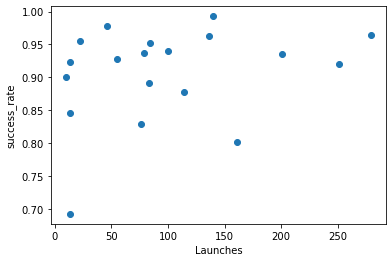

In [161]:
# plot the number of launches against success rate.
plt.plot(company_df_rktpce['Launches'], company_df_rktpce['success_rate'], 'o');
plt.xlabel('Launches')
plt.ylabel('success_rate')
plt.show()

It is unlikely that there is a relationship here. 

Is there a relationship between the number of launches per year and the yearly success rate? 

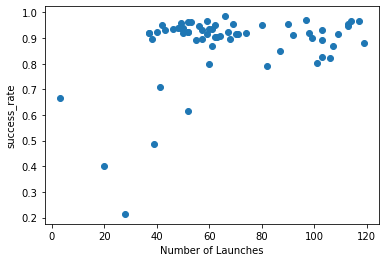

In [162]:
# Look at launches and success rate
plt.plot(YEAR_df.Launches, YEAR_df.success_rate, 'o');
plt.xlabel('Number of Launches')
plt.ylabel('success_rate')
plt.show()

It's unlikely that there is a significant relatinship here. But we can check using linear model. 

In [163]:
# Create simple linear fit model to see if the number of launches
# per year is related to success rate.

# create dataframe for X,y
X = YEAR_df[['Launches']]
y = YEAR_df['success_rate']

# split out some training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

# initialize and fit model
lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train) 

# predict response with testing dataset 
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train) 

# simple test metric of R2
train_score = r2_score(y_train, y_train_preds)
print(train_score)
test_score = r2_score(y_test, y_test_preds)
print(test_score)

0.14025825752007548
-0.00021890414969671923


R2 training and test scores are very low. We will need additional stats to determine if total number of launches per year show any relationship with launch success. 

# Does launch success improve with experience?

In [185]:
# Create column with total number of launches by year for that particular company.
# Create column with average success rate of past 5 launches for each company.

# Create column of all 1's to use as summation field.space_df['Index1'] = 1

# Create column to store cumulative values 
space_df['CumLaunches'] = 1

# Create column to store rolling average of success
space_df['success_mv_ave'] = 0

# create blank dataset to join
joindat = pd.DataFrame(columns = space_df.columns)

# Function to create cumulative launch number for each launch by company. 
# Example: for a given company, we want to see if the probability of success increases from
# the first to the last launch. Ie, does having more launches equate to higher launch success.
def create_sum_launches(df, joindat, companies):
    for cp in  companies:
            try:
                # create subset of launches for a given company and sort by date/time
                x = df[df['Company_Name'] == cp].sort_values(by=['date_time'])
                # get a running total of launches in the cumulative launches column
                x['CumLaunches'] = x.Index1.cumsum()
                # get a rolling average of success to be success rate of past 3 launches
                x['success_mv_ave'] = x.Success.rolling(window=5).mean()
                # set the dataframes to merge.
                frames = [joindat, x]
                joindat = pd.concat(frames, axis=0)
            except:
                continue
    return joindat

# Create list of Companies
companies = space_df.Company_Name.unique()

# Apply our function
cumulative_launches_df = create_sum_launches(space_df, joindat, companies)

# look at the resulting dataset
cumulative_launches_df.head()

,SucessFail,Company_Name,Rocket_Price,date_time,YEAR,MONTH,WEEK,WEEKDAY,Failure,Success,Index1,CumLaunches,success_mv_ave
929,Failure,SpaceX,7.0,2006-03-24,2006,3,12,Fri,1,0,1,1,NaN
879,Failure,SpaceX,7.0,2007-03-21,2007,3,12,Wed,1,0,1,2,NaN
808,Failure,SpaceX,7.0,2008-08-03,2008,8,31,Sun,1,0,1,3,NaN
800,Success,SpaceX,7.0,2008-09-28,2008,9,39,Sun,0,1,1,4,NaN
763,Success,SpaceX,7.0,2009-07-14,2009,7,29,Tue,0,1,1,5,0.4


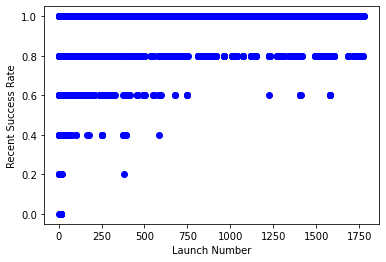

In [186]:
# Plot success by cumulative launches
plt.plot(cumulative_launches_df.CumLaunches, cumulative_launches_df.success_mv_ave, 'o', color='blue');
plt.xlabel('Launch Number')
plt.ylabel('Recent Success Rate')
plt.show()

There seems to be evidence that the cumulative launches to-date has a relationship with recent success rate, such that low cumulative launches equate to low (recent) success rates. However, low cumulative launches does not always equate to low success rate, as there are many instances of a high success rates with low cumulative launches. 

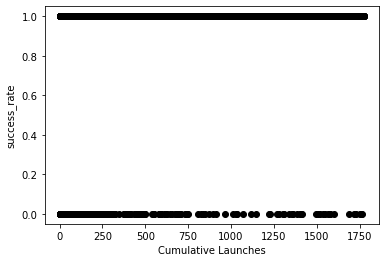

In [165]:
# Plot success by cumulative launches
plt.plot(cumulative_launches_df.CumLaunches, cumulative_launches_df.Success, 'o', color='black');
plt.xlabel('Launch Number')
plt.ylabel('success_rate')
plt.show()

Doesn't look like there is much evidence that cumulative launches = higher probability of success. Let's fit a simple linear regression model to explore this further. 

In [184]:
# Create simple linear fit model to see if the mean week 
# per year is related to success rate.

# create dataframe for X,y
# cumulative_launches_df = cumulative_launches_df.dropna() # remove missing values caused by moving average
X = cumulative_launches_df[['CumLaunches']]
y = cumulative_launches_df['Success']
# set y as integer for Logistic Regression
y=y.astype('int')

# split out some training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

# linear Regression
lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train) 

# predict response with testing dataset 
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train) 

# simple test metric of R2
train_score = r2_score(y_train, y_train_preds)
print(train_score)
test_score = r2_score(y_test, y_test_preds)
print(test_score)

0.0037016334013677543
-8.813166523302662e-05


Again, our testing and training R2 values are very low, indicating poor model fit. Clearly this model is not appropriate for these data. We will need to look into other model forms. There may be a threshold on cumulative launch experience, such that non-linear (GAM, or such) could be useful.